# Omega Aragonite Escape Velocity Regional Comparison

In [28]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from xhistogram.xarray import histogram

In [29]:
%matplotlib inline

In [30]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

---

## Surface k10 RCP85 Ensemble Average

In [31]:
# k10 Omega Arag for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP85/'
filename = 'omega_arag_k10_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

---

## Decadal Mean Omega Arag

In [32]:
# Calculate the time-mean Omega Arag for 15 decades of simulation
# 1959s through 2090s
da_oa_annual = ds.omega_arag.groupby('time.year').mean(dim='time', skipna=True)
da_oa_mean = []

decade = 1950
for i in range(15):
    dec_mean = decadal_mean(da_oa_annual, decade)
    da_oa_mean.append(dec_mean.squeeze())
    decade += 10

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Calculate Escape Vectors

In [33]:
# Definte projection transformations and coordiantes
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
lon = ds.xt_ocean.data
lat = ds.yt_ocean.data
# colors = cm.get_cmap('plasma', 10)
colors = ['hotpink','magenta','darkviolet','darkblue','blue',
          'dodgerblue','turquoise','limegreen','lime','gold',
          'darkorange','orangered','red','brown','maroon']
# Create levels array to isolate undersaturation threshold
clevs=[1]

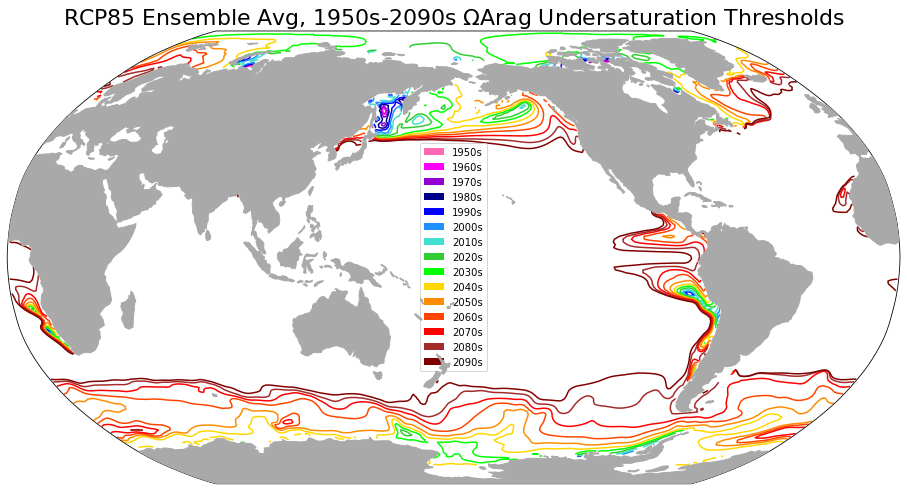

In [34]:
# Plot Velocities at undersaturation border for all decades
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

num_decades=15
decade=1950
legend_elements = []
for i in range(num_decades):
    element = Patch(facecolor=colors[i], label=str(decade)+'s')
    legend_elements.append(element)
    decade+=10
    
# Extract points from contour line segments for each decade
list_xpoints = []  # list contianing lists of x points for each decade
list_ypoints = []  # list contianing lists of y points for each decade
for i in range(num_decades):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i],transform=src)
    
    segments = cs.allsegs[0]
    num_segs = len(segments)
    
    xpoints = []  # to track multiple paths within same decade
    ypoints = []
    for j in range(num_segs):
        x = segments[j][:,0].tolist()  # convert to list to be easily concatenated
        y = segments[j][:,1].tolist()
        for p in x:
            xpoints.append(p)
        for p in y:
            ypoints.append(p)
    list_xpoints.append(xpoints)  # add list of x points for each decade
    list_ypoints.append(ypoints)  # add list of y points for each decade

ax.legend(handles=legend_elements, loc='center')
ax.set_global()

ax.set_title('RCP85 Ensemble Avg, 1950s-2090s $\Omega$Arag Undersaturation Thresholds',fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

fig.savefig('./oa_escape_vel_figs/oa_k10_contours_15')

In [35]:
# Round all values to nearest 0.5 (to be easily indexed)
# Create adjusted list to use later for indexing
list_xpoints_idx = []
list_ypoints_idx = []
for i in range(num_decades):  # list of lists
    xpoints = list_xpoints[i]  # individual list of xpoints
    ypoints = list_ypoints[i]  # individual list of ypoints
    num_points = len(xpoints)
    for p in range(num_points):
        xpoints[p] = round_half(xpoints[p])
        ypoints[p] = round_half(ypoints[p])
    xpoints = (np.array(xpoints)-0.5).tolist()
    ypoints = (np.array(ypoints)+89.5).tolist()
    
    list_xpoints_idx.append(xpoints)
    list_ypoints_idx.append(ypoints)

In [36]:
# For each contour, for 1950s-2090s, compute the minimum distance to 
# the contour of the next decade. i.e. for each x,y on the OA=1@2000 
# contour, find the closest OA=1@2010 contour.

# Create parallel arrays of list to hold lists of directions and vectors for each decade
list_vector_dx = []  # change in x for nearest points
list_vector_dy = []  # change in y for nearest points
list_vector_magnitude = []  # distance to nearest points

for i in range(num_decades-1):
    vector_dx = []  # change in x for decade
    vector_dy = []  # change in y for decade
    vector_magnitude = []  # vector magnitude for decade
    xpoints = list_xpoints[i]  # x coords for decade
    ypoints = list_ypoints[i]  # y coords for decade
    num_points = len(xpoints)
    # For each point, find min dist and closest point on contour 
    # of next decade
    for p in range(num_points):
        xp = xpoints[p] # x value along contour
        yp = ypoints[p] # y value along contour
        x,y,dx,dy,mindist = min_dist(xp,yp,
                                     list_xpoints[i+1],
                                     list_ypoints[i+1],
                                    da_oa_mean[i].data)
        # maintain lists of x and y vectors
        vector_dx.append(dx/1000)
        vector_dy.append(dy/1000)
        vector_magnitude.append(mindist/1000)  # dist magnitude
    
    list_vector_dx.append(vector_dx)
    list_vector_dy.append(vector_dy)
    list_vector_magnitude.append(vector_magnitude)

In [37]:
# Reformat data to be Mappable
nx = len(lon)
ny = len(lat)
da_escape_dist = []  # escape distances for each decade
da_escape_dx = []  # escape dx for each decade
da_escape_dy = []  # escape dy for each decade
# For each decade up to 2090s
for i in range(num_decades-1):
    # Create empty arrays and initialize all values to np.nan
    da_dx = np.zeros(shape=(nx,ny))
    da_dx[:,:] = np.nan
    da_dy = np.zeros(shape=(nx,ny))
    da_dy[:,:] = np.nan
    da_dist = np.zeros(shape=(nx,ny))
    da_dist[:,:] = np.nan
    # Iterate through points in array of contour point indices
    x_idx = list_xpoints_idx[i]
    y_idx = list_ypoints_idx[i]
    dx_vals = list_vector_dx[i]
    dy_vals = list_vector_dy[i]
    dist_vals = list_vector_magnitude[i]
    # For each contour point in the decade, save the escape vector
    # magnitude and direction in parallel DataArrays
    num_points = len(x_idx)
    for p in range(num_points):
        xi = int(x_idx[p])
        yi = int(y_idx[p])
        da_dx[xi,yi] = dx_vals[p]
        da_dy[xi,yi] = dy_vals[p]
        da_dist[xi,yi] = dist_vals[p]
    
    # Save out the vector (directionality and magnitude) fields as maps 
    # for each decade  
    da_dx = xr.DataArray(da_dx, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dx = da_dx.where(da_dx < np.inf)
    da_escape_dx.append(da_dx)
    da_dy = xr.DataArray(da_dy, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dy = da_dy.where(da_dy < np.inf)
    da_escape_dy.append(da_dy)
    da_dist = xr.DataArray(da_dist, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dist = da_dist.where(da_dist < np.inf)
    da_escape_dist.append(da_dist)

In [38]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

---

## Calculate Escape Velocity

In [39]:
# Calculate escape velocity and create DataArray
nx = len(lon)
ny = len(lat)
dec=1950
da_escape_vel = []
for i in range(num_decades-1):
    da_vel = da_escape_dist[i].copy().rename('Escape Velocity - '+str(dec)+'s')
    da_escape_vel.append(da_vel)
    dec+=10

In [40]:
# # comparison test
# da_escape_vel[7][140]

___

## Differentiate Regions

In [41]:
da_escvel_arctic = []  # Arctic ocean
da_escvel_equatorial = []  # Equatorial region
da_escvel_southern = []  # Southern ocean
for i in range(num_decades-1):
    da_escvel_arctic.append(da_escape_vel[i].loc[35:90,:].copy())
    da_escvel_equatorial.append(da_escape_vel[i].loc[-40:35,:].copy())
    da_escvel_southern.append(da_escape_vel[i].loc[-90:-40,:].copy())

In [42]:
# Define bin range and interval size
xlim = 1501
step = 50
levels = np.arange(0, xlim, step)
bins = np.array(levels)

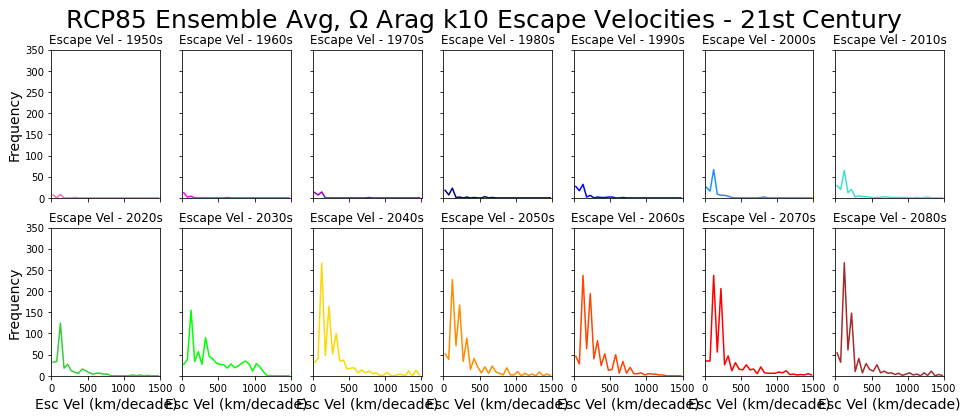

In [43]:
# Create Histograms for escape velocities
nrows=2
ncols=7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)

decade = 1950
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row,col]
        i = row*ncols + col
        h = histogram(da_escape_vel[i], bins=[bins])
        h.plot(ax=ax, color=colors[i])
        ax.set_title('Escape Vel - '+str(decade)+'s')
        ax.set_xlabel('Esc Vel (km/decade)',fontsize=14)
        ax.set_xlim(0,xlim)
        ax.set_xticks(np.arange(0, xlim, 500))
        ax.set_ylabel('Frequency',fontsize=14)
        ax.set_ylim(0,350)
        ax.label_outer()
#         ax.hist(da_escape_vel[i].data,bins=bins)
        decade+=10
    
    fig.suptitle('RCP85 Ensemble Avg, $\Omega$ Arag k10 Escape Velocities - 21st Century',
                fontsize=25)

In [44]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

In [45]:
# Calculate average Escape Velocities for different time periods
levels = np.arange(0, xlim, step)
bins = np.array(levels)

# da_escvel_equatorial
arctic_historic = hist_bins(da_escvel_arctic, levels, 0, 7)
arctic_future = hist_bins(da_escvel_arctic, levels, 7, 14)

# da_escvel_equatorial
equatorial_historic = hist_bins(da_escvel_equatorial, levels, 0, 7)
equatorial_future = hist_bins(da_escvel_equatorial, levels, 7, 14)

# da_escvel_southern
southern_historic = hist_bins(da_escvel_equatorial, levels, 0, 7)
southern_future = hist_bins(da_escvel_southern, levels, 7, 14)

# da_escape_vel
global_historic = hist_bins(da_escape_vel, levels, 0, 7)
global_future = hist_bins(da_escape_vel, levels, 7, 14)

In [46]:
# Average frequency per decade
# arctic_historic_mean = arctic_historic / 7
# arctic_future_mean = arctic_future / 7

# equatorial_historic_mean = equatorial_historic / 7
# equatorial_future_mean = equatorial_future / 7

# southern_historic_mean = southern_historic / 7
# southern_future_mean = southern_future / 7

# global_historic_mean = global_historic / 7
# global_future_mean = global_future / 7

# Percentage of Calculated Climate Velocities
arctic_historic_mean = arctic_historic / arctic_historic.sum()
arctic_future_mean = arctic_future / arctic_future.sum()

equatorial_historic_mean = equatorial_historic / equatorial_historic.sum()
equatorial_future_mean = equatorial_future / equatorial_future.sum()

southern_historic_mean = southern_historic / southern_historic.sum()
southern_future_mean = southern_future / southern_future.sum()

global_historic_mean = global_historic / global_historic.sum()
global_future_mean = global_future / global_future.sum()

In [47]:
# Create DataArrays for entire earth and individual regions
arctic_historic_mean = xr.DataArray(arctic_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('arctic_hist')
arctic_future_mean = xr.DataArray(arctic_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('arctic_future')
equatorial_historic_mean = xr.DataArray(equatorial_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('equatorial_hist')
equatorial_future_mean = xr.DataArray(equatorial_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('equatorial_future')
southern_historic_mean = xr.DataArray(southern_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('southern_hist')
southern_future_mean = xr.DataArray(southern_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('southern_future')
global_historic_mean = xr.DataArray(southern_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('global_hist')
global_future_mean = xr.DataArray(global_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('global_future')

In [48]:
# Define Legend and colormap
colorcmp = ['lightpink','plum','moccasin','coral','lawngreen','limegreen']
regions = ['Arctic (Historical)','Arctic (Future)',
           'Equatorial (Historical)','Equatorial (Future)',
          'Southern (Historical)','Southern (Future)']
legend_elements = []
num_colors = len(colorcmp)
for i in range(num_colors):
    element = Patch(facecolor=colorcmp[i], label=regions[i])
    legend_elements.append(element)

<ipython-input-49-e99bb3496e36>:8: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  d = scipy.zeros(num_bins)


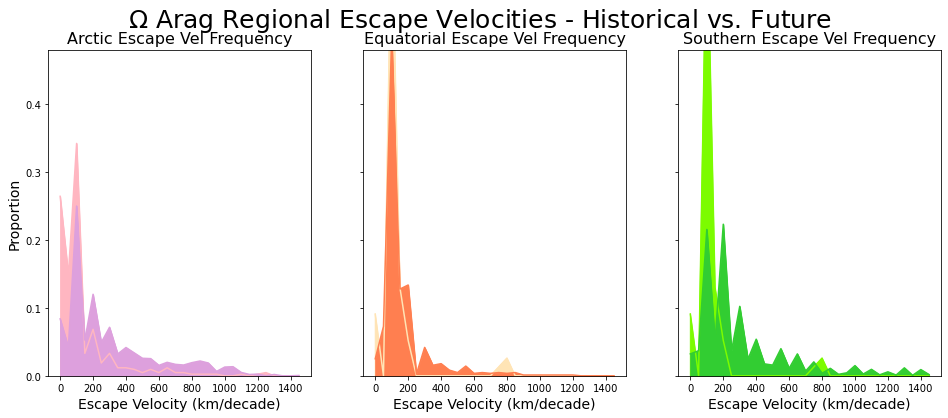

In [49]:
# Create Histograms for Different Regions' Escape Velocities
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)

num_bins = len(levels)-1
d = scipy.zeros(num_bins)
xs = np.arange(0,xlim-1,step)

# Arctic
ax = axs[0]
ys = arctic_historic_mean
ys.plot(ax=axs[0],color=colorcmp[0])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[0])
ys = arctic_future_mean
ys.plot(ax=ax,color=colorcmp[1])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[1])
ax.set_title('Arctic Escape Vel Frequency',fontsize=16)

# Equatorial
ax = axs[1]
ys = equatorial_historic_mean
ys.plot(ax=ax,color=colorcmp[2])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[2])
ys = equatorial_future_mean
ys.plot(ax=ax,color=colorcmp[3])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[3])
ax.set_title('Equatorial Escape Vel Frequency',fontsize=16)

# Southern
ax = axs[2]
ys = southern_historic_mean
ys.plot(ax=ax,color=colorcmp[4])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[4])
ys = southern_future_mean
ys.plot(ax=ax,color=colorcmp[5])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[5])
ax.set_title('Southern Escape Vel Frequency',fontsize=16)

for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=14)
    ax.set_ylabel('Proportion',fontsize=14)
    ax.set_ylim(0,0.48)
    ax.label_outer()
    
    fig.suptitle('$\Omega$ Arag Regional Escape Velocities - Historical vs. Future',
                fontsize=25)

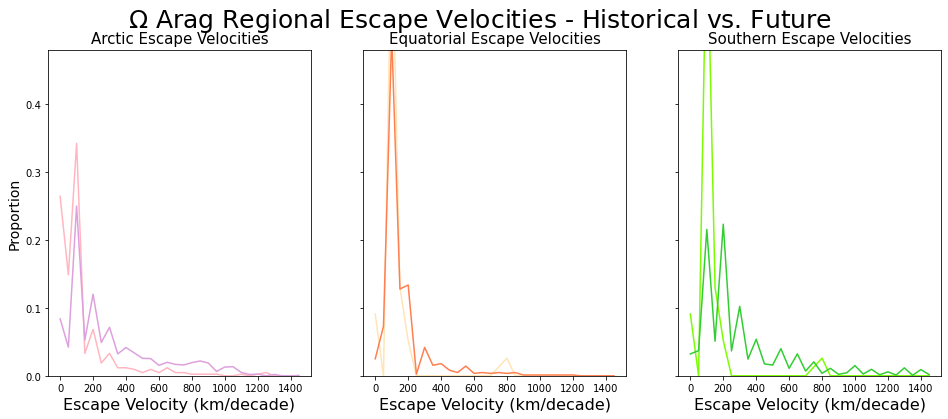

In [50]:
# Create Histograms for Different Regions' Escape Velocities
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0]
arctic_historic_mean.plot(ax=axs[0],color=colorcmp[0])
arctic_future_mean.plot(ax=ax,color=colorcmp[1])
ax.set_title('Arctic Escape Velocities',fontsize=15)
# Equatorial
ax = axs[1]
equatorial_historic_mean.plot(ax=ax,color=colorcmp[2])
equatorial_future_mean.plot(ax=ax,color=colorcmp[3])
ax.set_title('Equatorial Escape Velocities',fontsize=15)
# Southern
ax = axs[2]
southern_historic_mean.plot(ax=ax,color=colorcmp[4])
southern_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Southern Escape Velocities',fontsize=15)

for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_ylim(0,0.48)
    ax.label_outer()
    
    fig.suptitle('$\Omega$ Arag Regional Escape Velocities - Historical vs. Future',
                fontsize=25)

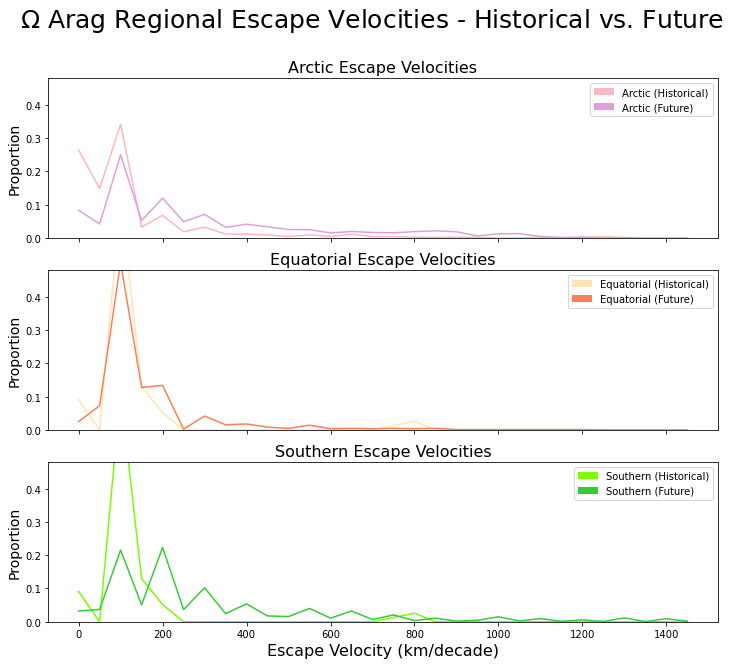

In [51]:
# Create Histograms for Different Regions' Escape Velocities
nrows=3
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,10], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0]
arctic_historic_mean.plot(ax=axs[0],color=colorcmp[0])
arctic_future_mean.plot(ax=ax,color=colorcmp[1])
ax.set_title('Arctic Escape Velocities',fontsize=16)
# Equatorial
ax = axs[1]
equatorial_historic_mean.plot(ax=ax,color=colorcmp[2])
equatorial_future_mean.plot(ax=ax,color=colorcmp[3])
ax.set_title('Equatorial Escape Velocities',fontsize=16)
# Southern
ax = axs[2]
southern_historic_mean.plot(ax=ax,color=colorcmp[4])
southern_future_mean.plot(ax=ax,color=colorcmp[5])
ax.set_title('Southern Escape Velocities',fontsize=16)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion',fontsize=14)
    ax.set_ylim(0,0.48)
    ax.label_outer()
    ax.legend(handles=legend_elements[i:i+2], loc='upper right')
    i+=2
    
    fig.suptitle('$\Omega$ Arag Regional Escape Velocities - Historical vs. Future',
                fontsize=25)

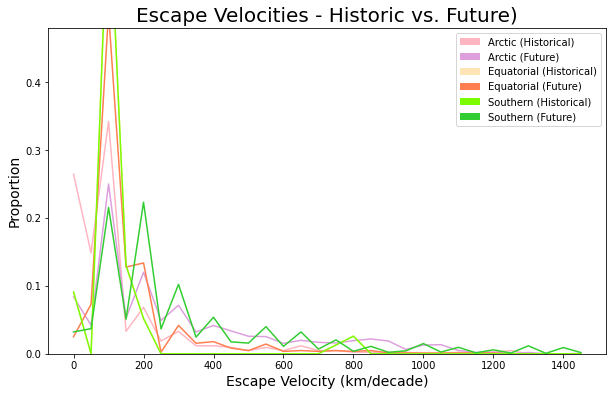

In [52]:
# Create Histogram for Different Regions' Escape Velocities (single plot)
fig, ax = plt.subplots(figsize=[10,6], 
                        sharex=True,sharey=True)

arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_future_mean.plot(ax=ax,color=colorcmp[1])
equatorial_historic_mean.plot(ax=ax,color=colorcmp[2])
equatorial_future_mean.plot(ax=ax,color=colorcmp[3])
southern_historic_mean.plot(ax=ax,color=colorcmp[4])
southern_future_mean.plot(ax=ax,color=colorcmp[5])

ax.set_title('Escape Velocities - Historic vs. Future)',fontsize=20)
ax.set_xlabel('Escape Velocity (km/decade)',fontsize=14)
ax.set_ylim(0,0.48)
ax.set_ylabel('Proportion',fontsize=14)
ax.label_outer()
ax.legend(handles=legend_elements, loc='upper right')

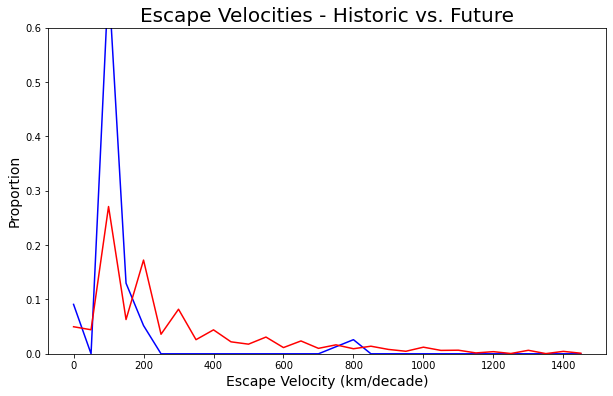

In [53]:
# Create Histogram for Different Regions' Escape Velocities (single plot)
fig, ax = plt.subplots(figsize=[10,6], 
                        sharex=True,sharey=True)

global_historic_mean.plot(ax=ax,color='b')
global_future_mean.plot(ax=ax,color='r')

ax.set_title('Escape Velocities - Historic vs. Future',fontsize=20)
ax.set_xlabel('Escape Velocity (km/decade)',fontsize=14)
ax.set_ylim(0,0.6)
ax.set_ylabel('Proportion',fontsize=14)
ax.label_outer()